In [1]:
from openai import OpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import List, Optional, Dict
import matplotlib.pyplot as plt
from enum import Enum
import numpy as np
import yaml
import pandas as pd
import os
load_dotenv()
client = OpenAI()



In [8]:

class GameEvent(BaseModel):
    stag: bool
    reasoning: str

class History(BaseModel):
    stag: bool
    period: int
    payoff: int

class Games(BaseModel):
    event: List[GameEvent] = Field(default_factory=list)

class GameHistory(BaseModel):
    history: List[History] = Field(default_factory=list)

HIGH_PAYOFF = 12

def run_agent_decision(system_prompt, game_prompt, name=None, model="gpt-4o-mini", response_format=GameEvent):
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": game_prompt}
    ]
    try:
        response = client.beta.chat.completions.parse(
            model=model, 
            messages=messages,
            response_format=response_format
            )
        results = response_format.model_validate_json(response.choices[0].message.content).model_dump()
        results['name'] = name
        results['model'] = model
        return results
    except Exception as e:
        raise e


In [ ]:

def calculate_payoff(game_type: str, decisions: Dict[str, bool], starting_payoff: int) -> Dict[str, int]:
    payoffs = {}
    if game_type == 'play_for_pair':
        players = ['A', 'B', 'C', 'D']
        decision_A = decisions.get('A', False)
        decision_C = decisions.get('C', False)
        if decision_A and decision_C:
            # Both players play Stag
            for player in players:
                payoffs[player] = HIGH_PAYOFF
        elif decision_C:
            # Only Player C played stag.
            payoffs['A'] = 8
            payoffs['D'] = 8  
            payoffs['B'] = 1
            payoffs['C'] = 1
        elif decision_A: 
            # Only Player A played stag.
            payoffs['C'] = 8
            payoffs['B'] = 8 
            payoffs['A'] = 1
            payoffs['D'] = 1
        else:
            # Neither player added the link; all players get starting payoff
            for player in players:
                payoffs[player] = 8
    elif game_type == 'play_for_self':
        decision_P1 = decisions.get('Player1', False)
        decision_P2 = decisions.get('Player2', False)
        if decision_P1 and decision_P2:
            payoffs['Player1'] = HIGH_PAYOFF
            payoffs['Player2'] = HIGH_PAYOFF
        elif decision_P1:
            payoffs['Player1'] = 8
            payoffs['Player2'] = 1
        elif decision_P2:
            payoffs['Player1'] = 1
            payoffs['Player2'] = 8
        else:
            payoffs['Player1'] = 8
            payoffs['Player2'] = 8
    return payoffs


def get_history_summary(name: str, histories: Dict[str, GameHistory]) -> str:
    summary = "Summary of Previous Periods:\n"
    _histories = {}
    for _name, history in histories.items():
        if _name == name:
            __name = "You"
        __name = "You" if _name == name else _name
        
        for h in history.history:
            decision_str = "played stag" if h.stag else "played hare"
            summary += f"- Period {h.period}: {__name} {decision_str}. Payoff: {h.payoff} units.\n"
    return summary

def run_round(game_type: str, period: int, agents: Dict[str, Dict], histories: Dict[str, GameHistory], starting_payoff: int, model="gpt-4o-mini"):
    decisions = {}
    for name, agent_info in agents.items():
        # Read the game prompt from the prompt file
        with open(agent_info['prompt_file'], "r") as f:
            game_prompt_template = f.read()
        # Generate the history summary
        history = histories.get(name)
        if history and history.history:
            history_summary = get_history_summary(name, histories)
        else:
            history_summary = ""
        
        print(history_summary)
        print()
        # Replace placeholders in the prompt
        game_prompt = game_prompt_template + "\n" + history_summary
        game_prompt = game_prompt.replace("Period N", f"Period {period}")
        game_prompt = game_prompt.replace("{player_role}", agent_info['role'])
        
        # Run agent decision
        decision_result = run_agent_decision(
            system_prompt=agent_info['system_prompt'],
            game_prompt=game_prompt,
            name=name,
            model=model,
            response_format=GameEvent
        )
        decisions[name] = decision_result['stag']
        print(f"{name} ({decision_result['stag']}): {decision_result['reasoning']}")
    # Calculate payoffs
    payoffs = calculate_payoff(game_type, decisions, starting_payoff)
    # Update histories for all players
    if game_type == 'play_for_pair':
        all_players = ['A', 'B', 'C', 'D']
    elif game_type == 'play_for_self':
        all_players = ['Player1', 'Player2']
    for name in all_players:
        history = histories.setdefault(name, GameHistory())
        stag = decisions[name]
        payoff = payoffs[name]
        history.history.append(History(
            period=period,
            stag=stag,
            payoff=payoff
        ))
    return decisions, payoffs

def run_game(game_type: str, sessions, rounds=15, starting_payoff=9, model="gpt-4o-mini"):
    all_histories = []
    system_prompt = open('./prompts/system_prompt_2.txt', 'r').read()
    play_for_pair_prompt = './prompts/play_for_pair_4.txt'
    play_for_self_prompt = './prompts/play_for_self_4.txt'

    if game_type == 'play_for_pair':
        # For each group
        for group_num in range(1, sessions + 1):
            agents = {}
            histories = {}
            # Players A and C are active
            agents['A'] = {
                'role': 'Player A',
                'prompt_file': play_for_pair_prompt,
                'system_prompt': system_prompt
            }
            agents['C'] = {
                'role': 'Player C',
                'prompt_file': play_for_pair_prompt,
                'system_prompt': system_prompt
            }
            histories['A'] = GameHistory()
            histories['C'] = GameHistory()
            # Run rounds
            for period in range(1, rounds + 1):
                decisions, payoffs = run_round(game_type, period, agents, histories, starting_payoff=starting_payoff, model=model)
                # Optionally, print or log the results of the round
                print(f"Group {group_num}, Period {period} results:")
                print(f"Decisions: {decisions}")
                print(f"Payoffs: {payoffs}")
            # Collect histories for aggregation
            all_histories.append(histories)
    elif game_type == 'play_for_self':
        # For each agent
        for agent_num in range(1, sessions + 1):
            agents = {}
            histories = {}
            agent_name = f'Player{agent_num}'
            agents[agent_name] = {
                'role': agent_name,
                'prompt_file': play_for_self_prompt,
                'system_prompt': system_prompt
            }
            histories[agent_name] = GameHistory()
            # Run rounds
            for period in range(1, rounds + 1):
                decisions, payoffs = run_round(game_type, period, agents, histories, starting_payoff=starting_payoff, model=model)
                # Optionally, print or log the results of the round
                print(f"Agent {agent_name}, Period {period} results:")
                print(f"Decisions: {decisions}")
                print(f"Payoffs: {payoffs}")
            # Collect histories for aggregation
            all_histories.append(histories)
    # Return all histories for analysis
    return all_histories


In [3]:
def run_game_type(game_type, starting_payoff=9, rounds=15):
    if game_type == 'play_for_pair':
        sessions = 12  # 4 players per session
    elif game_type == 'play_for_self':
        sessions = 24  # 2 players per session

    all_histories = run_game(game_type=game_type, sessions=sessions, rounds=rounds, starting_payoff=starting_payoff, model="gpt-4o-mini")
    data = []
    for session, histories in enumerate(all_histories):
        for name, history in histories.items():
            for h in history.history:
                data.append({
                    'session': session + 1,
                    'player': name,
                    'period': h.period,
                    'stag': h.stag,
                    'payoff': h.payoff
                })
    df = pd.DataFrame(data) 
    return df


In [4]:
game_type = 'play_for_pair'
pp_df = run_game_type(game_type)

total_decisions = len(pp_df)
yes_decisions = pp_df[pp_df['stag'] == True].shape[0]
percentage_yes = (yes_decisions / total_decisions) * 100

print(f"Total decisions: {total_decisions}")
print(f"Total 'Yes' decisions: {yes_decisions}")
print(f"Percentage of 'Yes' decisions for {game_type}: {percentage_yes:.2f}%")



A (False): Choosing Hare guarantees a better outcome regardless of the other team's decision.


C (False): Choosing Hare guarantees a higher reward regardless of the other team's choice.
Group 1, Period 1 results:
Decisions: {'A': False, 'C': False}
Payoffs: {'A': 8, 'B': 8, 'C': 8, 'D': 8}
Summary of Previous Periods:
- Period 1: You played hare. Payoff: 8 units.
- Period 1: C played hare. Payoff: 8 units.


A (False): I choose Hare to secure a consistent payoff of 8 units for my team, given the unpredictability of the other team's choice.
Summary of Previous Periods:
- Period 1: A played hare. Payoff: 8 units.
- Period 1: You played hare. Payoff: 8 units.


C (False): Choosing Hare guarantees a solid payoff of 8 units based on the previous period's outcomes.
Group 1, Period 2 results:
Decisions: {'A': False, 'C': False}
Payoffs: {'A': 8, 'B': 8, 'C': 8, 'D': 8}
Summary of Previous Periods:
- Period 1: You played hare. Payoff: 8 units.
- Period 2: You played hare. Payoff: 8 units.
-

In [7]:
game_type = 'play_for_self'
ps_df = run_game_type(game_type)

total_decisions = len(ps_df)
yes_decisions = ps_df[ps_df['stag'] == True].shape[0]
percentage_yes = (yes_decisions / total_decisions) * 100

print(f"Total decisions: {total_decisions}")
print(f"Total 'Yes' decisions: {yes_decisions}")
print(f"Percentage of 'Yes' decisions for {game_type}: {percentage_yes:.2f}%")



Player1 (False): Choosing Hare consistently yields a higher guaranteed reward.


KeyError: 'Player2'

In [ ]:
pp_df.to_csv('./dist/pp_df_5.csv', index=False)
ps_df.to_csv('./dist/ps_df_5.csv', index=False)

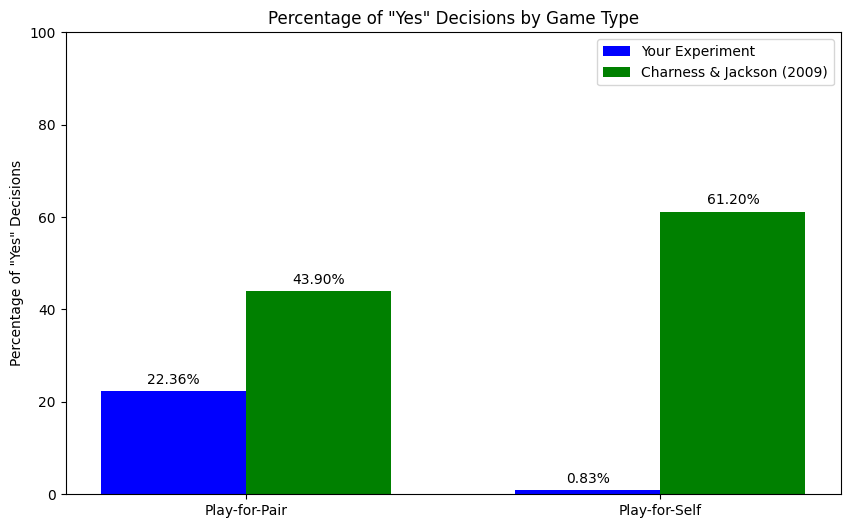

In [ ]:
## Percentages

# Play-for-Pair
pp_total_decisions = len(pp_df)
pp_yes_decisions = pp_df[pp_df['stag'] == True].shape[0]
pp_percentage_yes = (pp_yes_decisions / pp_total_decisions) * 100

# Play-for-Self
ps_total_decisions = len(ps_df)
ps_yes_decisions = ps_df[ps_df['stag'] == True].shape[0]
ps_percentage_yes = (ps_yes_decisions / ps_total_decisions) * 100

# Your experiment's percentages
your_percentages = [pp_percentage_yes, ps_percentage_yes]

# Papers Results
paper_pp_percentage = 43.9
paper_ps_percentage = 61.2

paper_percentages = [paper_pp_percentage, paper_ps_percentage]

# Data for plotting
game_types = ['Play-for-Pair', 'Play-for-Self']
x = np.arange(len(game_types))  # the label locations
width = 0.35  # the width of the bars

# Create the bar chart
plt.figure(figsize=(10, 6))
rects1 = plt.bar(x - width/2, your_percentages, width, label='Your Experiment', color=['blue'])
rects2 = plt.bar(x + width/2, paper_percentages, width, label='Charness & Jackson (2009)', color=['green'])

# Add percentage labels on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.2f}%',
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Chart formatting
plt.title('Percentage of "Yes" Decisions by Game Type')
plt.ylabel('Percentage of "Yes" Decisions')
plt.xticks(x, game_types)
plt.ylim(0, 100)
plt.legend()

plt.show()


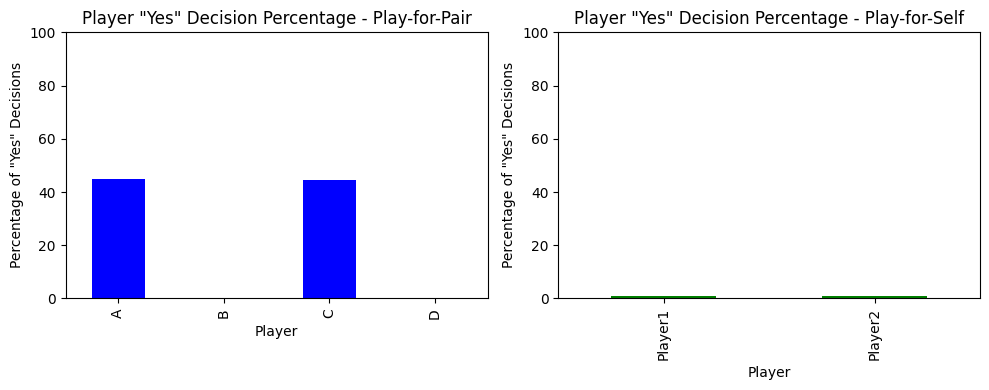

In [ ]:
# Calculate percentage of "Yes" decisions per player for Play-for-Pair
pp_player_percentages = pp_df.groupby('player')['decision'].mean() * 100

# Calculate percentage of "Yes" decisions per player for Play-for-Self
ps_player_percentages = ps_df.groupby('player')['decision'].mean() * 100

# Plotting for Play-for-Pair
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
pp_player_percentages.plot(kind='bar', color='blue')
plt.title('Player "Yes" Decision Percentage - Play-for-Pair')
plt.xlabel('Player')
plt.ylabel('Percentage of "Yes" Decisions')
plt.ylim(0, 100)

# Plotting for Play-for-Self
plt.subplot(1, 2, 2)
ps_player_percentages.plot(kind='bar', color='green')
plt.title('Player "Yes" Decision Percentage - Play-for-Self')
plt.xlabel('Player')
plt.ylabel('Percentage of "Yes" Decisions')
plt.ylim(0, 100)

plt.tight_layout()
plt.show()


In [ ]:
print(pp_df['payoff'].value_counts())
print(ps_df['payoff'].value_counts())

payoff
8    322
9    256
1    142
Name: count, dtype: int64
payoff
9    708
8      6
1      6
Name: count, dtype: int64
